In [1]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-11-18

Goals: 
Fit the data

Each Section can/should run independently,
only these initial imports should be shared among all sections

Open questions:
None at the moment
"""

import numpy as np
import pandas as pd
import pyarrow as pa

# from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

from tqdm import tqdm

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
import dask
# many workers
# dask.config.set(scheduler='threads') 

# does not work
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(20))

# one worker
# dask.config.set(scheduler='processes')  
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
# cluster.adapt(minimum=10, maximum=40) 

In [3]:
ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36424,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:42216,Total threads: 8
Dashboard: http://127.0.0.1:43679/status,Memory: 83.97 GiB
Nanny: tcp://127.0.0.1:41017,


# Setup base directory for saving output files

In [5]:
username= "ncaplar"
basedir = f"/astro/users/{username}/data/"

# Tape Single Pixel - real data 

## loading and inspection of the data

In [4]:
# if running on baldur or epyc
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=False,
                 sort=False,
                 )

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/tape/ensemble.py:1116: UserWarning: Divisions for object are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/tape/ensemble.py:1116: UserWarning: Divisions for source are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(


Filter data

In [7]:
ens.query("band_ztf_source == 'g'", table = 'source')
ens.prune(10)
ens.query("rMeanPSFMag_ps1_otmo < 20", table = 'object')

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/tape/ensemble.py:1577: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [9]:
ens._object.compute()

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,yMeanPSFMag_ps1_otmo,yMeanPSFMagErr_ps1_otmo,yFlags_ps1_otmo,Norder_ps1_otmo,Dir_ps1_otmo,Npix_ps1_otmo,_DIST,Norder,Dir,nobs_total
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
024341.05-010243.3,4996749735944519680,4240,55455,178,40.921044,-1.045386,4240-55455-0178,BOSS,2.369000,VI,...,19.193501,0.039844,115000,5,0,4438,0.000016,5,0,252
024234.93-010351.9,4996754941277110272,6782,56572,334,40.645567,-1.064436,6782-56572-0334,BOSS,1.373000,VI,...,19.281900,0.050055,115000,5,0,4438,0.000004,5,0,241
024347.34-005354.9,4996771631947841536,3651,55247,294,40.947287,-0.898595,3651-55247-0294,BOSS,0.237000,VI,...,18.469999,0.044246,16892216,5,0,4438,0.000009,5,0,279
024347.11-004949.3,4996775603542687744,6782,56572,297,40.946311,-0.830385,6782-56572-0297,BOSS,0.565000,VI,...,19.084700,0.032752,115000,5,0,4438,0.000015,5,0,45
024425.39-004653.0,4996818172750331904,6782,56602,218,41.105805,-0.781410,6782-56602-0218,BOSS,0.936000,VI,...,18.399401,0.061579,115000,5,0,4438,0.000013,5,0,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
024419.10+005539.2,4997824956667527168,6782,56572,772,41.079588,0.927557,6782-56572-0772,BOSS,0.821000,VI,...,19.677601,0.056099,115000,5,0,4438,0.000017,5,0,346
024221.87+004912.7,4997837085797777408,9381,57758,79,40.591144,0.820204,9381-57758-0079,BOSS,2.060000,VI,...,17.924200,0.020761,115000,5,0,4438,0.000016,5,0,370
024200.53+005322.2,4997845805743210496,6782,56572,610,40.502233,0.889509,6782-56572-0610,BOSS,0.964000,VI,...,18.615900,0.030714,115000,5,0,4438,0.000010,5,0,657


/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

(17.0, 21.0)

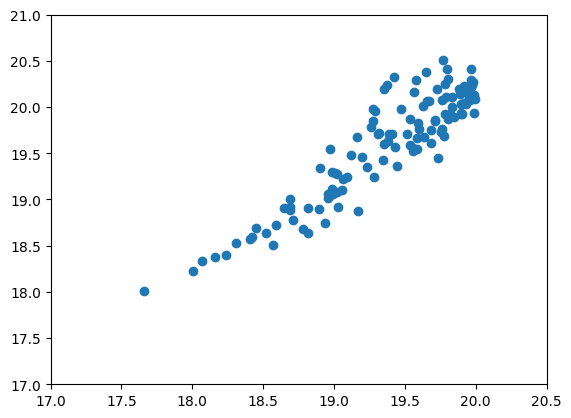

In [10]:
plt.scatter(ens._object['rMeanPSFMag_ps1_otmo'].compute().values, ens._object['gMeanPSFMag_ps1_otmo'].compute().values)
plt.xlim(17,20.5)
plt.ylim(17,21)

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

(17.0, 23.0)

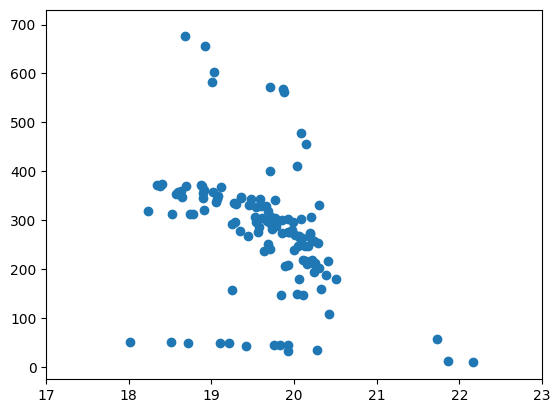

In [12]:
ens_nobs = ens.calc_nobs(temporary=False)

plt.scatter( ens._object['gMeanPSFMag_ps1_otmo'].compute().values,ens_nobs._object['nobs_total'].compute().values)
plt.xlim(17,23)

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

(array([ 4.,  9.,  4.,  0.,  1.,  0.,  2.,  3.,  3.,  4.,  7.,  6.,  8.,
        13., 14.,  7., 17.,  7.,  6.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  1.]),
 array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190., 210.,
        230., 250., 270., 290., 310., 330., 350., 370., 390., 410., 430.,
        450., 470., 490., 510., 530., 550., 570., 590., 610., 630., 650.,
        670., 690., 710.]),
 <BarContainer object of 35 artists>)

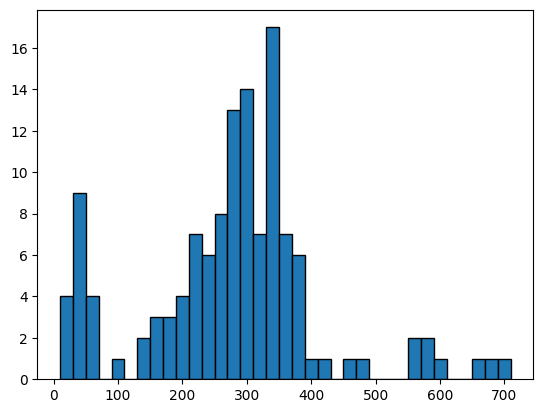

In [13]:

data = ens_nobs._object['nobs_total'].compute().values

bin_edges = range(min(data), max(data) + 21, 20) 
plt.hist(data, bins=bin_edges, edgecolor='k')  # 'k' sets black color for edges

## Computation

In [14]:
# 9min, 13 sec on baldur, for 603 sources in 4 partitions
# 7min, 30 sec on baldur, for 603 sources in 4 partitions, Nov 7
# 5min, 14 sec on baldur, for 603 sources in 10 partitions, Nov 7
# 2min, 50 sec on baldur, for 127 sources in 4 partitions
# 5min, 3 sec on epyc, for 127 sources in 4 partitions
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/tape/ensemble.py:1556: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [15]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

In [16]:
def pack_output_to_parquet(result, cols, output_dir, output_filename, drop_cols=[], full=False):
    """Packs output to a dataframe, written as a parquet file. The created dataframe object is returned for inspection."""
    result_df = None
    if full:
        # Construct dataframes with the results for each object.
        dfs = []
        for i in range(len(result)):
            obj_data = result.iloc[i]
            # Construct a series representing the index
            obj_index = pd.Series(np.full(len(obj_data), result.index[i]), name=result.index.name)
            dfs.append(pd.DataFrame(data=obj_data, columns=cols, index=obj_index))

        # Concatenate all of the per-object dataframes
        result_df = pd.concat(dfs)
    else:
        # Each object only has a 1D array in the result series, so the constructed
        # dataframe has the same number of rows. So we can just do a 1:1 mapping with column names 
        result_df = pd.DataFrame(columns=cols, index=result.index)
        for i in range(len(result)):
            result_df.iloc[i] = result[i]

    # Drop any columns if requested.
    if drop_cols:
        result_df = result_df.drop(columns=drop_cols)

    # Write the output to the parquet file
    pa_table = pa.Table.from_pandas(result_df)
    pa_table
    pa.parquet.write_table(pa_table, f"{output_dir}/data/{output_filename}.parquet")
    return result_df

# Create columns for result of using just the drw kernel
param_cols = ['log_drw_scale', 'log_drw_amp']
init_param_cols = ["init_" + c for c in param_cols]
drw_columns = ['min_neg_log_lh', 'neg_log_lh'] + param_cols + init_param_cols

# Create columns for result of combining the drw params with periodic params
param_cols = ['log_drw_scale', 'log_drw_amp', 'log_per_scale', 'log_per_amp']
init_param_cols = ["init_" + c for c in param_cols]
combined_columns = ['min_neg_log_lh', 'neg_log_lh'] + param_cols + init_param_cols


In [17]:
# Save output for results from just the drw kernel
drw_df = pack_output_to_parquet(res_tsp_drw, drw_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_drw")
drw_df

/tmp/ipykernel_61320/2460734338.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_df.iloc[i] = result[i]


,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,init_log_drw_scale,init_log_drw_amp
SDSS_NAME_dr16q_constant,,,,,,
024050.36-003109.0,40.08991,40.08991,2.980099,-0.760837,3.534287,0.225864
024052.82-004110.9,-34.805998,-34.805998,-3.807629,-4.933484,0.979914,0.808098
024126.71-004526.3,-28.434609,-28.434609,2.066565,-1.24888,1.872701,-2.842854
024151.76-001953.6,35.285865,35.285865,2.441909,-1.277017,3.854836,-1.304851
024154.42-004757.6,-12.792811,-12.792811,1.545028,-4.170314,1.554912,-1.710292
...,...,...,...,...,...,...
024419.10+005539.2,-94.10112,-94.10112,2.633371,-0.931073,2.623782,-2.06715
024448.90+002858.6,-72.338187,-72.338187,2.415671,-0.888955,3.037724,-0.912945
024504.47+002841.3,13.080527,13.080527,2.468771,-0.839532,1.792329,1.68365


In [18]:
# Save output for results from the combined drw and periodic kernel
combined_df = pack_output_to_parquet(res_tsp, combined_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0")
combined_df

/tmp/ipykernel_61320/2460734338.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_df.iloc[i] = result[i]


,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,log_per_scale,log_per_amp,init_log_drw_scale,init_log_drw_amp,init_log_per_scale,init_log_per_amp
SDSS_NAME_dr16q_constant,,,,,,,,,,
024050.36-003109.0,39.083982,39.083982,3.0885,-0.715306,1.468924,-1.164669,1.460723,-1.409983,0.468374,-1.184457
024052.82-004110.9,-35.156772,-35.156772,-12.49335,-10.902907,2.738975,-1.331822,0.232252,-0.446263,3.155693,-2.31874
024126.71-004526.3,-29.632743,-29.632743,-10.076967,-6.401982,2.944183,-1.101969,0.780093,1.537832,3.032145,-1.003249
024151.76-001953.6,31.643813,31.643813,2.550391,-1.240236,1.469939,-1.185938,4.436064,-0.351747,1.432706,-0.935809
024154.42-004757.6,-12.792812,-12.792812,3.320252,-1.58099,-0.159079,-2.115329,2.137705,1.485551,1.079105,-1.820266
...,...,...,...,...,...,...,...,...,...,...
024419.10+005539.2,-97.450038,-97.450038,2.66236,-1.459577,2.504225,-1.096036,3.645036,-2.128168,2.507581,-2.122817
024448.90+002858.6,-75.779812,-75.779812,2.488547,-1.149155,2.834314,-0.926675,4.609371,-1.789724,2.784006,-1.233347
024504.47+002841.3,12.178009,12.178009,2.478015,-1.004705,3.046591,-0.992085,1.792329,1.68365,3.509834,-0.760212


# Redo but save all results (full=True)

In [ ]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_full = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100, full=True)

In [ ]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw_full = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100, full=True)

In [ ]:
# Save output for results from just the drw kernel
drw_df_full = pack_output_to_parquet(res_tsp_drw_full, drw_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_drw_full", full=True)
drw_df_full

In [ ]:
# Save output for results from the combined drw and periodic kernel
combined_df_full = pack_output_to_parquet(res_tsp_full, combined_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_full", full=True)
combined_df_full

# Alerce alerts

In [6]:
datapath = "/astro/store/epyc3/data3/alerce_alerts/parquet/"

names = []
for i in range(12,36):
    name = datapath+f"source/lcs_00{i}.parquet"
    names.append(name)

# Ensemble already initialized in the start
# ens = Ensemble()

colmap = ColumnMapper(id_col="oid",
                      time_col="mjd",
                      flux_col="magpsf_corr",
                      err_col="sigmapsf_corr_ext",
                      band_col="fid")
ens.from_parquet(source_file=names,
                #source_file=datapath+"source/lcs_000*.parquet",
                 #object_file=datapath+"object/*.parquet",
                 column_mapper=colmap,
                 sort=True)

ens.dropna()
ens.query("fid == 1", table="source").prune(30)

ens.calc_nobs()
ens._sync_tables()

In [7]:
ens._source._meta

,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,magpsf,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,


In [9]:
# to see where the divisions are
divisions = ens._source.divisions
divisions

('ZTF17aaaaabc',
 'ZTF17aabpkdd',
 'ZTF17aacnjdr',
 'ZTF18aajsckg',
 'ZTF18aamvggu',
 'ZTF18aayuvtb',
 'ZTF18aazgcja',
 'ZTF18abaeiar',
 'ZTF18abcnqvd',
 'ZTF18abgcsem',
 'ZTF18abhjzuq',
 'ZTF18abijkqj',
 'ZTF18abmofow',
 'ZTF18abrwpzx',
 'ZTF18absrvbu',
 'ZTF18abttinn',
 'ZTF18acebheq',
 'ZTF18actvwav',
 'ZTF18adatmvu',
 'ZTF19aadosny',
 'ZTF19aaxkgdr',
 'ZTF19abddqrx',
 'ZTF20aabkuej',
 'ZTF20abivuft',
 'ZTF23abawsji')

In [15]:
# takes 5 minutes for this silly algorithm
n_sources_per_div =[]
for i in tqdm(range(len(divisions)-1)):
    n_sources_per_div.append(ens._source[divisions[0]:divisions[1]].compute().shape[0])
    
n_sources_per_div

100%|██████████| 24/24 [04:58<00:00, 12.44s/it]


[156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519,
 156519]

In [10]:
ens._source.npartitions

24

In [11]:
ens._source.head(5)


,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,magpsf,...,sigmagapbig,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaace,939443434315010039,58693.443437,1,939443434315,20.405657,-1,939,71.805881,47.974764,18.651217,...,0.1284,743120143.0,18.248980,0.054240,0.061382,True,False,9.474716e+17,False,bulk_1.0.0
ZTF17aaaaace,947471584315015034,58701.471586,1,947471584315,20.489890,1,947,71.805877,47.974547,19.853916,...,0.2733,743120143.0,17.541601,0.016220,0.022079,True,False,9.734760e+17,False,bulk_1.0.0
ZTF17aaaaace,970475794315010048,58724.475799,1,970475794315,20.611511,-1,970,71.805921,47.974756,18.732740,...,0.0997,743120143.0,18.196066,0.048942,0.056075,True,False,9.734760e+17,False,bulk_1.0.0
ZTF17aaaaace,973476034315010032,58727.476030,1,973476034315,20.517332,-1,973,71.805931,47.974767,19.155125,...,0.1420,743120143.0,18.001198,0.037810,0.044190,True,False,1.002489e+18,False,bulk_1.0.0
ZTF17aaaaace,1002429524315010048,58756.429526,1,1002429524315,20.631700,-1,1002,71.805831,47.974742,19.551924,...,0.2243,743120143.0,17.892044,0.023578,0.031366,True,False,1.002489e+18,False,bulk_1.0.0


In [12]:
# how many objects
print(len(ens._object))


31892


unique_lengths: 336


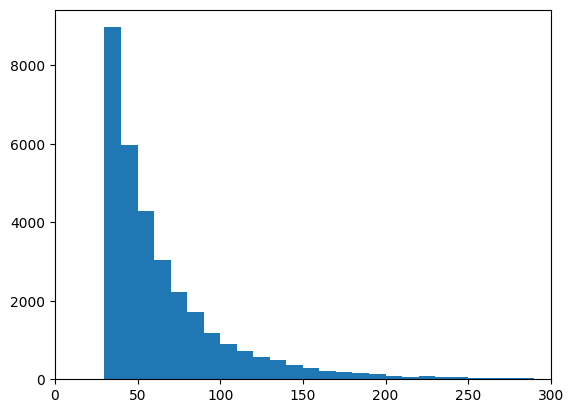

In [13]:
nobs_data = ens._object["nobs_total"].values.compute()
binwidth=10
plt.hist(nobs_data, bins=np.arange(min(nobs_data), max(nobs_data) + binwidth, binwidth))
plt.xlim(0,300)

print(f"unique_lengths: {len(np.unique(nobs_data))}")

# ZTF